# 統計モデルの記述とサンプリングの実行

アリスとボブのレポートを確率的プログラミングを使った統計的仮設検定をしていく

| アリスのレポート | A案 | B案 |
| :--: | :--: | :--: |
| 表示回数 | 40 | 50 |
| クリック数 | 2 | 4 |
| クリック率 | 5% | 8% |

| ボブのレポート | A案 | B案 |
| :--: | :--: | :--: |
| 表示回数 | 1280 | 1600 |
| クリック数 | 64 | 128 |
| クリック率 | 5% | 8% |

P21で定義した通り  
事前分布は一様分布  
$ \theta \sim Uniform(0, 1) $


その尤度関数は二項分布  
$ \alpha \sim Binomial(\theta, N) $

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pymc3 as pm

In [3]:
N = 40 # アリスのデザインA案の表示数
a = 2 # アリスのデザインA案のクリック数

with pm.Model() as model: #統計モデルオブジェクトを生成
    theta = pm.Uniform('theta', lower = 0, upper = 1) # pm.Uniformは一様分布を表すクラス 確率変数thetaが取りうる値を1~0の間に限定
    obs = pm.Binomial('a', p=theta, n=N, observed=a) # pm.Binomialは二項分布を表すクラス 試行の成功確率thetaと試行回数Nの二つのパラメータを持たせる。
                                                    # 二項分布から生成される確率変数a = 合計クリック数は観測されているので a = 2を渡す
    trace = pm.sample(5000, chains=2) # pm.sampleで推論を実行　第一引数は抽出したいサンプル数(今回は5000個の乱数) chainsは並行してサンプリングを行う数 つまり今回は10000個のサンプルが得られる

### 上で6000×2回のサンプリングをしている理由
MCMCの初期段階のサンプルは品質が悪くなるから  
初期値はランダムに設定されるので、最適なパラメータからとても離れた場所からスタートする可能性がある。  
初期値の影響を取り除くために捨ててしまう期間のことを**バーンイン**という  

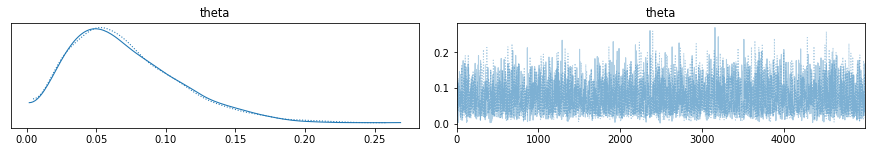

In [6]:
# サンプルが格納された変数traceを可視化
with model:
    pm.traceplot(trace)

左が推論された事後分布  
右がバーンイン後に得られたサンプルの軌跡  （横軸はサンプリングの回数, 縦軸はサンプルされた確率変数の値）  
右側の分布がある一定の帯を中心に分布していたら、（蛇行していない。横に真っ直ぐの分布になっている）ならオッケー  
そうじゃなかったら、バーンイン期間を長めにとったり、事前分布を見直したり、統計モデルそのものを見直す

In [8]:
# 代表的な要約統計量を表示
with model:
    print(pm.summary(trace, hdi_prob=0.95))

        mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_mean  \
theta  0.072  0.039     0.009       0.15      0.001      0.0    4658.0   

       ess_sd  ess_bulk  ess_tail  r_hat  
theta  4658.0    4112.0    4638.0    1.0  


#### 上の出力の見方
mean: 標本平均  
sd: 標準偏差  
hdi_2.5%: 95%HDIの下限  
hdi_97.5%: 95%HDIの上限  

HDI: Highest Density Interval 確率変数の値を確率密度が大きいものから順にある確率に至るまでカバーしたもの  
0.95HDIは確率0.95を占めるまで確率密度が高いものから埋めていった区域

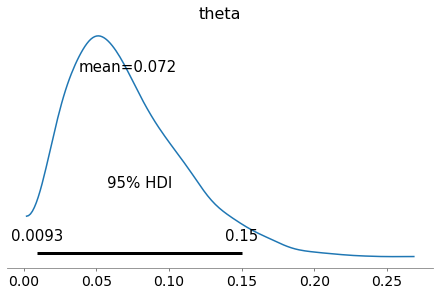

In [9]:
# 事後分布を要約統計量とともに可視化
with model:
    pm.plot_posterior(trace, hdi_prob=0.95)

図1-24と似たような分布が確認できた。

## 仮説： アリスのデザインA案のクリック率は1%以上である　を検証する
この仮説を以下の定量評価を用いて検証する

定量的評価： 新たな確率変数$\sigma = \theta - 0.01$のサンプルが95%の確率で正の値になる  

MCMCによって得られた確率変数$\theta$の事後分布のサンプルを格納した配列 $trace['theta']$ に対してこの定量的評価を与える

In [10]:
print((trace['theta'] - 0.01 > 0).mean())

0.9918


⬆︎0.95を超えたので、この定量的評価方法のもとでアリスのデザインA案のクリック率は1%以上である。

In [11]:
# デザインB案も同様に実行してみる
with pm.Model() as model:
    theta = pm.Uniform('theta', lower=0, upper=1, shape=2) # shape引数を渡すことで、同じ事前分布に従う複数の確率変数を指定できる。
    obs = pm.Binomial('obs', p=theta, n=[40,50], observed=[2,4]) # observedにも観測した複数のデータを配列として一気に渡せる
    trace = pm.sample(5000, chains=2)

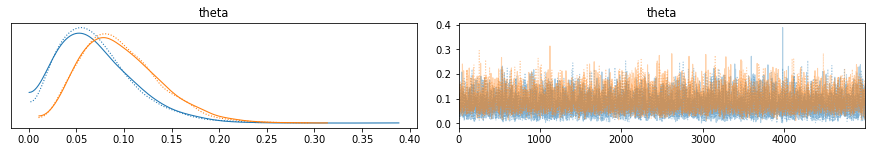

In [12]:
with model:
    pm.traceplot(trace, ['theta'], compact=True)

大部分が重なり合っている。  

## 仮説： デザインB案のクリック率はデザインA案よりも大きい　を検証する

この仮説を以下の定量指標を用いて検証する

定量的評価: $\delta = \theta_B - \theta_A$のサンプルが95%の確率で正の値になる  

$trace['theta']$は(生成したサンプルの数, 確率変数の数) = (10000, 2)のサイズを持つ配列  
A案のサンプルは$trace['theta'][:, 0]$  
B案のサンプルは$trace['theta'][:, 1]$

In [18]:
print((trace['theta'][:,1]-trace['theta'][:, 0] > 0).mean())

0.681


1.7.3で得られた結果と一致している

0.9994


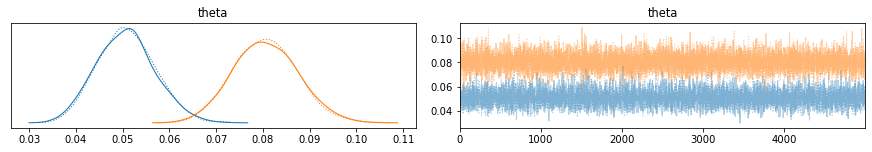

In [20]:
# ボブでも同様に出してみる
with pm.Model() as model:
    theta = pm.Uniform('theta', lower=0, upper=1, shape=2)
    obs = pm.Binomial('obs', p=theta, n=[1280, 1600], observed=[64, 128])
    trace = pm.sample(5000, chains=2)
    print((trace['theta'][:, 0] < trace['theta'][:, 1]).mean())
    pm.traceplot(trace, ['theta'], compact=True)

95%の意思決定ラインを超えている  
ボブのレポート結果から、B案のクリック率がA案のクリック率を超えていると結論付けられた

# 真のレビュースコア
ユーザーの投票によってつけられた評価値： レビュースコア  

| 商品 | 1点 | 2点 | 3点 | 4点 | 5点 | 合計人数 | 平均点 |
| :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: |
| A | 20 | 10 | 36 | 91 | 170 | 327 | 4.17 |
| B | 0 | 0 | 4 | 0 | 6 | 10 | 4.20 |

上記のそれぞれの商品の平均点はどれほど信頼できるのか  

この事象を表すカテゴリ分布は$p(r|\boldsymbol{\theta})$  
ここでの$\boldsymbol{\theta}$は$\theta$と異なり、ベクトル  

なぜなら今回扱うデータはクリックしたかしないかの2値のデータではなく5つのカテゴリーを持つデータだから  
$\boldsymbol{\theta} = (\theta_{1点}, \theta_{2点}, \theta_{3点}, \theta_{4点}, \theta_{5点})$  

事前分布$p(\boldsymbol{\theta})$について考える  
今回欲しいのは複数カテゴリの離散値を出力する確率分布なのでカテゴリカル分布$Categorical(\boldsymbol{\theta})$が適している(図1-4と似たケース）  
ベルヌーイ分布の共役事前分布であるベータ分布を二個以上のカテゴリーを扱うように拡張した確率分布 => **ディレクレ分布**  

ディレクレ分布:  
- K次元のベクトルの確率変数$\boldsymbol\theta$が従う確率分布 ($0\leqq \theta_n \leqq 1$ , $\sum_{n=1}^{K}{\theta_n}=1$) 
- 集中度と呼ばれるK次元ベクトル$\alpha$をパラメータとして持つ（$\alpha$は正の実数）  

事前分布に対する知識は０なので$\alpha$を全て１とする  
$\boldsymbol{\theta} \sim Dirichlet(\boldsymbol{\alpha} = (1,1,1,1,1))$  
$r \sim Categorical(\boldsymbol{\theta})$

In [22]:
# 商品Aに対する推論

n_a = [20, 10, 36, 91, 170]
# 観測データに相当する配列dataにそれぞれのレビュアーの数だけ対応する値を入れていく
data = [0 for _ in range(n_a[0])]
data += [1 for _ in range(n_a[1])]
data += [2 for _ in range(n_a[2])]
data += [3 for _ in range(n_a[3])]
data += [4 for _ in range(n_a[4])]

with pm.Model() as model_a:
    theta = pm.Dirichlet('theta', a=np.array([1,1,1,1,1])) # 事前分布にディレクレ分布を使用
    obs = pm.Categorical('obs', p=theta, observed=data) # 尤度関数にカテゴリカル分布を使用
    trace_a = pm.sample(5000, chains=2)

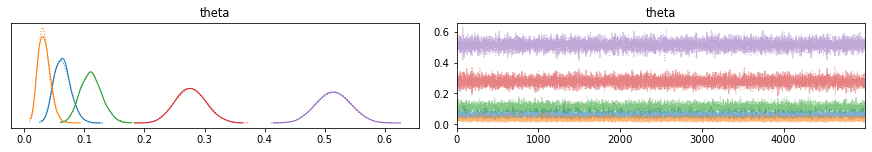

In [23]:
# MCMCの結果、得られた軌跡を可視化
with model_a:
    pm.traceplot(trace_a)

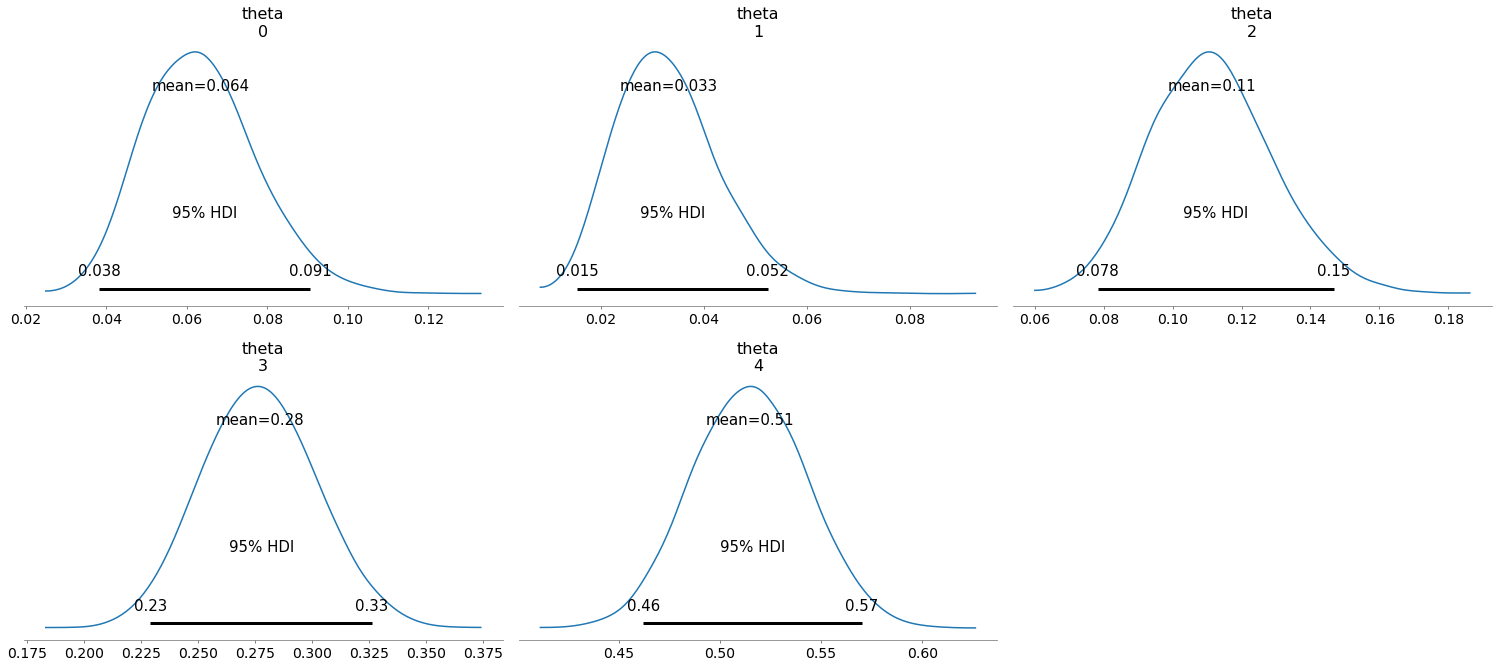

In [24]:
# パラメータθの事後分布について詳しくみる
with model_a:
    pm.plot_posterior(trace_a, hdi_prob=0.95)

$\theta_1$や$\theta_2$は0.1以下のところに分布が寄っているので、レビュースコア1,2点がつけられる確率は低い  
$\theta_4$は95%HDIが0.5付近にあるので、半数近くが5点をつけている  

次に最終的に知りたいレビュースコアの平均点に相当する変数mを設定  
$m=1\theta_{1点} + 2\theta_{2点} + 3\theta_{3点} + 4\theta_{4点} + 5\theta_{5点}$  
m: 各レビュースコアが発生する確率の重みで加重平均したもの

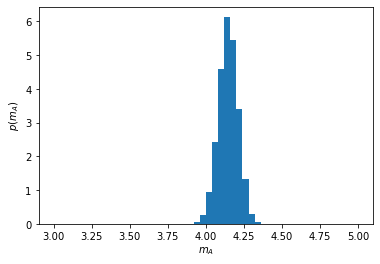

In [26]:
# レビュースコアをweightと定義、確率θを掛け合わせて和をとる
weights = np.array([1,2,3,4,5])
m_a = [sum(row * weights) for row in trace_a['theta']]

#ここで得られた確率分布p(m)をヒストグラムにする
plt.hist(m_a, range=(3,5), bins=50, density=True)
plt.xlabel(r'$m_A$')
plt.ylabel(r'$p(m_A)$')
plt.show()

商品Aのレビュースコアは4~4.3の狭い区間に集中していることがわかる

商品Bについてデータが生成される過程を変更する
カテゴリカル分布をN回分まとめたもの： **多項分布（multinomial distribution）**

多項分布は
- K個のカテゴリを扱うことができる
- 試行回数を表すNと、それぞれのカテゴリが発生する確率を表すK次元のベクトル$\boldsymbol{\theta}$
- N回の試行の結果各カテゴリが発生した合計回数を表す確率変数$\boldsymbol{r}$が多項分布に従う

事前分布には先ほど同様にディレクレ分布, 尤度関数に多項分布を用いる  
$\boldsymbol{\theta} \sim Dirichlet(\boldsymbol{\alpha} = (1,1,1,1,1))$  
$\boldsymbol{\alpha} \sim Multinomial(\boldsymbol{\theta)}$  

これをプログラミングモデルに落とし込んで商品Bの各レビュースコアが現れる確率$\boldsymbol{\theta}$を事後分布を求める

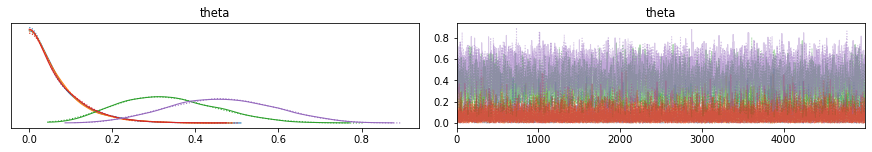

In [28]:
n_b = np.array([0,0,4,0,6]) # 各レビュースコアが現れた回数
with pm.Model() as model_b: 
    theta = pm.Dirichlet('theta', a=np.array([1,1,1,1,1])) # 
    obs = pm.Multinomial('obs', p=theta, n=n_b.sum(), observed=n_b) # 尤度関数として多項分布を呼び出す 各結果が現れる確率theta, 試行回数 n_b.sum()をパラメータに渡す 観測データn_b
    trace_b = pm.sample(5000, chains=2)
    pm.traceplot(trace_b)

裾が広い事後分布

レビュースコアの平均点の確率変数mを定義してレビュースコア平均点の確率分布を示す

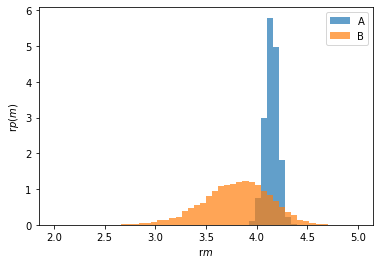

In [39]:
m_b = [sum(row*weights) for row in trace_b['theta']]
plt.hist(m_a, range=(2, 5), bins=50, density=True, label='A', alpha=0.7)
plt.hist(m_b, range=(2, 5), bins=50, density=True, label='B', alpha=0.7)
plt.xlabel('r$m$')
plt.ylabel('r$p(m)$')
plt.legend()
plt.show()

このサンプルサイズでは商品Bのレビュースコアの平均点は3.0~4.5の間にあるというのが限界  

# 滞在時間をテストする

連続値で表されるものに対して仮説検定する  

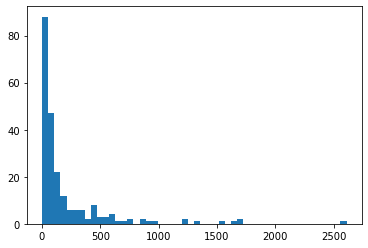

In [40]:
# 滞在時間データをダウンロードする
import urllib
url = 'https://www.oreilly.co.jp/pub/9784873119168/data/time-on-page.csv'
response = urllib.request.urlopen(url)
data = [int(row.strip()) for row in response.readlines()]
plt.hist(data, bins=50)
plt.show()

指数分布を尤度関数として採用する。  
指数関数の期待値は$\theta$, 分散は$\theta^2$  
指数関数の確率密度関数は以下の式で表される  
$p(x | \theta) = \frac{e^{\frac{-x}{\theta}}}{\theta}$  

事前分布に関しては一切知識が無いので、一様分布をパラメータ$\theta$の事前分布とする  
最小値パラメータ$\alpha$は$\theta > 0$なので0, 最大値パラメータ$\beta$は上記分布を見て十分だと思える範囲である3000に指定  
統計モデルは以下のようになる  

$\theta \sim Uniform(0, 3000)$  
$t \sim Exponential(\theta)$

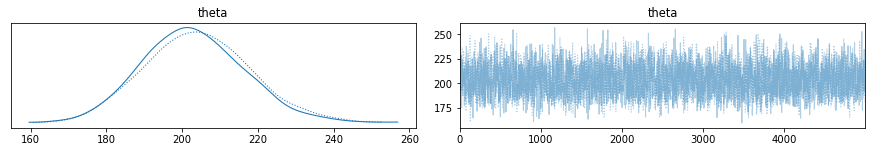

In [43]:
with pm.Model() as model:
    theta = pm.Uniform('theta', lower=0, upper=3000)
    obs = pm.Exponential('obs', lam=1/theta, observed=data) # 尺度パラメータθの代わりにその逆数であるレートパラメータλ = 1/θを引数とする
    trace = pm.sample(5000, chains=2)
    pm.traceplot(trace)

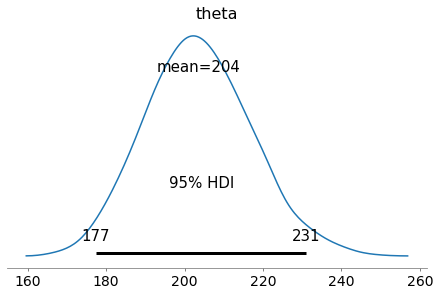

In [44]:
# MCMCによって得られた確率変数θの事後分布を図示
with model:
    pm.plot_posterior(trace, hdi_prob=0.95)

指数分布の期待値は$\theta$なので、このグラフはそのまま滞在時間の期待値の確率分布として扱える  
ほとんどが177~231秒の間に収まることがわかった  
実際はほとんどのユーザーが数秒で離脱している  
この期待値$\theta$は現状のサイトデザイン案のポテンシャルを表していると言える

# なぜベイズ推論による統計的仮設検定を行うのか

## ベイズ推論を用いない統計的仮設検定: NHST
**null hypothesis significance testing(NHST)**とは「帰無仮説」と「対立仮説」を用いた検定方法  
「こうなるだろう」という帰無仮説を設定  
その帰無仮説が成立した場合の確率分布と標本分布を計算  
実際の観測データがどれだけその分布に乗るのかを確認  
事前に設定した評価ラインを下回ったら、帰無仮説を棄却して、それを否定する仮説である対立仮説を採択する  
というロジック